##  違約預測（分類）


### 共通事前處理

In [ ]:
# 取得中文字型
!wget 'https://github.com/flyingpath/electron-hand-dicom/raw/master/TaipeiSansTCBeta-Regular.ttf'

--2022-05-29 09:08:16--  https://github.com/flyingpath/electron-hand-dicom/raw/master/TaipeiSansTCBeta-Regular.ttf
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/flyingpath/electron-hand-dicom/master/TaipeiSansTCBeta-Regular.ttf [following]
--2022-05-29 09:08:17--  https://raw.githubusercontent.com/flyingpath/electron-hand-dicom/master/TaipeiSansTCBeta-Regular.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  --.-KB/s    in 0.09s   

2022-05-29 09:08:18 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager as fm

fm.fontManager.addfont('./TaipeiSansTCBeta-Regular.ttf')
from IPython.display import display

np.set_printoptions(suppress=True, precision=4)
# 設定pandas浮點數表示方式
pd.options.display.float_format = '{:.4f}'.format
pd.set_option("display.max_columns",None)
# 指定圖形預設字體大小及字型
plt.rcParams["font.size"] = 14
plt.rcParams['font.family'] = 'Taipei Sans TC Beta'

In [ ]:
# 混淆矩陣
def make_cm(matrix, columns):
    # matrix numpy 陣列

    # columns 項目名稱列表
    n = len(columns)

    # 將 '標準答案' 重複 n 次以生成列表
    act = ['標準答案'] * n
    pred = ['預測結果'] * n

    # 生成資料框
    cm = pd.DataFrame(matrix,
        columns=[pred, columns], index=[act, columns])
    return cm

### 5.1.4 從載入資料到確認資料

#### 載入資料

In [ ]:
import random
import os


# 將 bank-full.csv 載入資料框中
df_all = pd.read_csv('Loan_Default.csv')



#### 確認資料

In [ ]:
# 確認資料框的內容
display(df_all.head())

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,Neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,Secured_by,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,NaN,NaN,360.0000,not_neg,not_int,not_lpsm,118000.0000,sb,pr,home,1U,1740.0000,EXP,758,CIB,25to34,to_inst,98.7288,south,direct,1,45.0000
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,NaN,NaN,360.0000,not_neg,not_int,lpsm,NaN,sb,pr,home,1U,4980.0000,EQUI,552,EXP,55to64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.5600,0.2000,595.0000,360.0000,neg_amm,not_int,not_lpsm,508000.0000,sb,pr,home,1U,9480.0000,EXP,834,CIB,35to44,to_inst,80.0197,south,direct,0,46.0000
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.2500,0.6810,NaN,360.0000,not_neg,not_int,not_lpsm,658000.0000,sb,pr,home,1U,11880.0000,EXP,587,CIB,45to54,not_inst,69.3769,North,direct,0,42.0000
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.0000,0.3042,0.0000,360.0000,not_neg,not_int,not_lpsm,758000.0000,sb,pr,home,1U,10440.0000,CRIF,602,EXP,25to34,not_inst,91.8865,North,direct,0,39.0000


In [ ]:
#確認資料分布
# 確認訓練資料的筆數與項目數
print(df_all.shape)
print()

# 確認「違約率」的分佈
print(df_all['Status'].value_counts())
print()

# 違約率
rate = df_all['Status'].value_counts()[1]/len(df_all)
print(f'違約率 : {rate:.4f}')

(148670, 34)

0    112031
1     36639
Name: Status, dtype: int64

違約率 : 0.2464


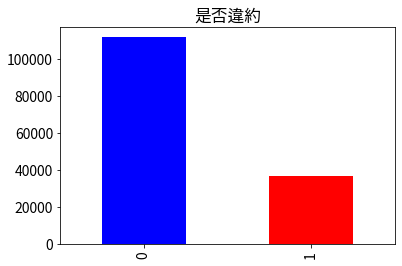

In [ ]:
df_all['Status'].value_counts().plot(kind='bar',title='是否違約',color=['blue', 'red'])

In [ ]:
# 確認缺失值
df1=df_all[df_all['Status']==1]
print(df1.isnull().sum()) #找出違約資料並觀察遺失值狀況

ID                               0
year                             0
loan_limit                     881
Gender                           0
approv_in_adv                  241
loan_type                        0
loan_purpose                    35
Credit_Worthiness                0
open_credit                      0
business_or_commercial           0
loan_amount                      0
rate_of_interest             36439
Interest_rate_spread         36639
Upfront_charges              36486
term                            15
Neg_ammortization               32
interest_only                    0
lump_sum_payment                 0
property_value               15096
construction_type                0
occupancy_type                   0
Secured_by                       0
total_units                      0
income                        1239
credit_type                      0
Credit_Score                     0
co-applicant_credit_type         0
age                            200
submission_of_applic

In [ ]:
df_all=df_all.drop(['rate_of_interest','Interest_rate_spread','Upfront_charges','property_value','dtir1','ID','LTV','year'],axis=1) #找出違約資料並刪除遺失值過多的欄位以及id、年份這兩個不具分析價值的欄位
print(df_all.isnull().sum()) #刪除任一欄位含有遺失值的資料

loan_limit                   3344
Gender                          0
approv_in_adv                 908
loan_type                       0
loan_purpose                  134
Credit_Worthiness               0
open_credit                     0
business_or_commercial          0
loan_amount                     0
term                           41
Neg_ammortization             121
interest_only                   0
lump_sum_payment                0
construction_type               0
occupancy_type                  0
Secured_by                      0
total_units                     0
income                       9150
credit_type                     0
Credit_Score                    0
co-applicant_credit_type        0
age                           200
submission_of_application     200
Region                          0
Security_Type                   0
Status                          0
dtype: int64


In [ ]:

df_all=df_all.replace("Unknow",np.nan)
df_all=df_all.replace("Unknow",np.nan).dropna()
print(df_all.isnull().sum())

loan_limit                   0
Gender                       0
approv_in_adv                0
loan_type                    0
loan_purpose                 0
Credit_Worthiness            0
open_credit                  0
business_or_commercial       0
loan_amount                  0
term                         0
Neg_ammortization            0
interest_only                0
lump_sum_payment             0
construction_type            0
occupancy_type               0
Secured_by                   0
total_units                  0
income                       0
credit_type                  0
Credit_Score                 0
co-applicant_credit_type     0
age                          0
submission_of_application    0
Region                       0
Security_Type                0
Status                       0
dtype: int64


In [ ]:
# 確認訓練資料的筆數與項目數
print(df_all.shape)
print()

# 確認「違約率」的分佈
print(df_all['Status'].value_counts())
print()

# 違約率
rate = df_all['Status'].value_counts()[1]/len(df_all)
print(f'違約率 : {rate:.4f}')

(135108, 26)

0    100881
1     34227
Name: Status, dtype: int64

違約率 : 0.2533


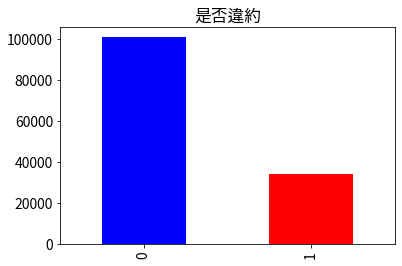

In [ ]:
df_all['Status'].value_counts().plot(kind='bar',title='是否違約',color=['blue', 'red'])

#### 預處理資料

In [ ]:
# 針對非連續性變數進行 One-Hot 編碼之函式
def enc(df, column):
    df_dummy = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df.drop([column],axis=1),df_dummy],axis=1)
    return df

df_all2 = df_all.copy()
df_all2 = enc(df_all2, 'loan_limit')
df_all2 = enc(df_all2, 'Gender')
df_all2 = enc(df_all2, 'approv_in_adv')
df_all2 = enc(df_all2, 'loan_type')
df_all2 = enc(df_all2, 'loan_purpose')
df_all2 = enc(df_all2, 'Credit_Worthiness')
df_all2 = enc(df_all2, 'open_credit')
df_all2 = enc(df_all2, 'business_or_commercial')
df_all2 = enc(df_all2, 'age')
df_all2 = enc(df_all2, 'Neg_ammortization')
df_all2 = enc(df_all2, 'interest_only')
df_all2 = enc(df_all2, 'lump_sum_payment')
df_all2 = enc(df_all2, 'construction_type')
df_all2 = enc(df_all2, 'occupancy_type')
df_all2 = enc(df_all2, 'Secured_by')
df_all2 = enc(df_all2, 'total_units')
df_all2 = enc(df_all2, 'credit_type')
df_all2 = enc(df_all2, 'co-applicant_credit_type')
df_all2 = enc(df_all2, 'submission_of_application')
df_all2 = enc(df_all2, 'Region')
df_all2 = enc(df_all2, 'Security_Type')
# 確認結果
display(df_all2.head())

,loan_amount,term,income,Credit_Score,Status,loan_limit_cf,loan_limit_ncf,Gender_Female,Gender_Joint,Gender_Male,Gender_Sex Not Available,approv_in_adv_nopre,approv_in_adv_pre,loan_type_type1,loan_type_type2,loan_type_type3,loan_purpose_p1,loan_purpose_p2,loan_purpose_p3,loan_purpose_p4,Credit_Worthiness_l1,Credit_Worthiness_l2,open_credit_nopc,open_credit_opc,business_or_commercial_b/c,business_or_commercial_nob/c,age_25to34,age_35to44,age_45to54,age_55to64,age_65to74,age_74over,age_under25,Neg_ammortization_neg_amm,Neg_ammortization_not_neg,interest_only_int_only,interest_only_not_int,lump_sum_payment_lpsm,lump_sum_payment_not_lpsm,construction_type_mh,construction_type_sb,occupancy_type_ir,occupancy_type_pr,occupancy_type_sr,Secured_by_home,Secured_by_land,total_units_1U,total_units_2U,total_units_3U,total_units_4U,credit_type_CIB,credit_type_CRIF,credit_type_EQUI,credit_type_EXP,co-applicant_credit_type_CIB,co-applicant_credit_type_EXP,submission_of_application_not_inst,submission_of_application_to_inst,Region_North,Region_North-East,Region_central,Region_south,Security_Type_Indriect,Security_Type_direct
0,116500,360.0000,1740.0000,758,1,1,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1
1,206500,360.0000,4980.0000,552,1,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,1
2,406500,360.0000,9480.0000,834,0,1,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1
3,456500,360.0000,11880.0000,587,0,1,0,0,0,1,0,1,0,1,0,0,0,0,0,1,1,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,0,1
4,696500,360.0000,10440.0000,602,0,1,0,0,1,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,1,0,1,0,0,0,0,1


#### 分割資料

In [ ]:
random_seed = 123
# 分割輸入資料與標準答案
x = df_all2.drop('Status', axis=1)
y = df_all2['Status'].values

# 分割訓練資料與驗證資料
# 以訓練資料 60%、驗證資料 40% 的比例分割
test_size = 0.4

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
  x, y, test_size=test_size, random_state=random_seed,
  stratify=y)

#### 選擇演算法

In [ ]:
#邏輯斯迴歸
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
algorithm = LogisticRegression(random_state=random_seed)
algorithm =algorithm.fit(x_train, y_train)
y_predicted=algorithm.predict(x_test)
print('分類正確率',metrics.accuracy_score(y_test,y_predicted))
print(metrics.classification_report(y_test,y_predicted))

分類正確率 0.7466693805047739
              precision    recall  f1-score   support

           0       0.75      1.00      0.85     40353
           1       0.00      0.00      0.00     13691

    accuracy                           0.75     54044
   macro avg       0.37      0.50      0.43     54044
weighted avg       0.56      0.75      0.64     54044



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#SVM
from sklearn import metrics
from sklearn.svm import SVC
algorithm = SVC(kernel='rbf',random_state=random_seed)
algorithm=algorithm.fit(x_train,y_train)
y_predicted=algorithm.predict(x_test)
print('分類正確率',metrics.accuracy_score(y_test,y_predicted))
print(metrics.classification_report(y_test,y_predicted))

分類正確率 0.7472799940788987
              precision    recall  f1-score   support

           0       0.75      1.00      0.86     40353
           1       0.68      0.00      0.01     13691

    accuracy                           0.75     54044
   macro avg       0.71      0.50      0.43     54044
weighted avg       0.73      0.75      0.64     54044



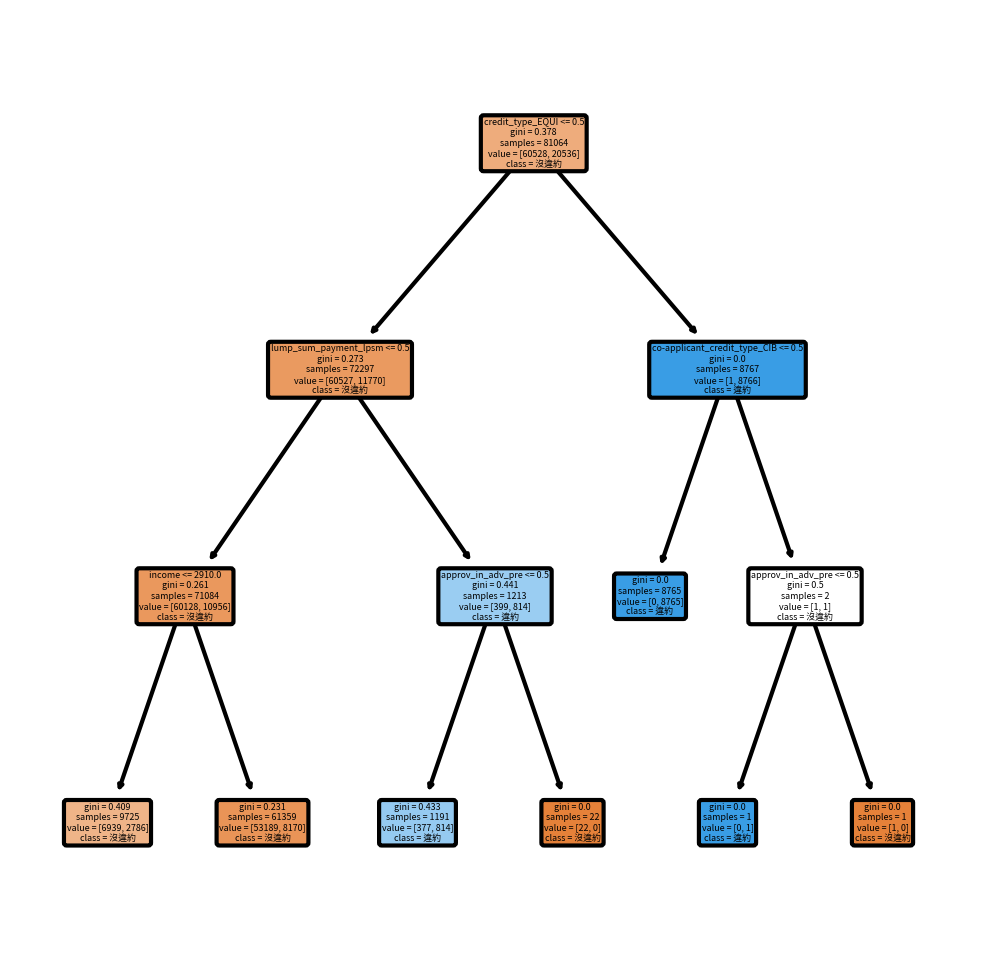

In [ ]:
#決策樹
# 訓練
from sklearn.tree import DecisionTreeClassifier
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
algorithm = DecisionTreeClassifier(max_depth=3,random_state=random_seed)
algorithm =algorithm.fit(x_train,y_train)

# 繪製決策樹的樹狀結構
from sklearn import tree

import pydotplus
from IPython.display import Image
iclass=['沒違約','違約']
tree.plot_tree(algorithm,feature_names=x_train.columns,class_names=iclass,filled=True,rounded=True)
fig.savefig('imagename.png')

In [ ]:
y_predicted=algorithm.predict(x_test)
print('分類正確率',metrics.accuracy_score(y_test,y_predicted))
print(metrics.classification_report(y_test,y_predicted))

分類正確率 0.8592813263266967
              precision    recall  f1-score   support

           0       0.85      0.99      0.91     40353
           1       0.96      0.47      0.63     13691

    accuracy                           0.86     54044
   macro avg       0.90      0.73      0.77     54044
weighted avg       0.87      0.86      0.84     54044



In [ ]:
# 隨機森林
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
algorithm = RandomForestClassifier(random_state=random_seed)
algorithm =algorithm.fit(x_train,y_train)
y_predicted=algorithm.predict(x_test)
print('分類正確率',metrics.accuracy_score(y_test,y_predicted))
print(metrics.classification_report(y_test,y_predicted))

分類正確率 0.8660350825253497
              precision    recall  f1-score   support

           0       0.86      0.98      0.92     40353
           1       0.90      0.53      0.67     13691

    accuracy                           0.87     54044
   macro avg       0.88      0.76      0.79     54044
weighted avg       0.87      0.87      0.85     54044



In [ ]:
# XGBoost
from xgboost import XGBClassifier
from sklearn import metrics
algorithm = XGBClassifier(random_state=random_seed)
algorithm=algorithm.fit(x_train,y_train)
y_predicted=algorithm.predict(x_test)
print('分類正確率',metrics.accuracy_score(y_test,y_predicted))
print(metrics.classification_report(y_test,y_predicted))

分類正確率 0.8705684257271853
              precision    recall  f1-score   support

           0       0.86      0.99      0.92     40353
           1       0.96      0.51      0.67     13691

    accuracy                           0.87     54044
   macro avg       0.91      0.75      0.79     54044
weighted avg       0.88      0.87      0.86     54044



In [ ]:
# 將候選演算法建立成列表

# 邏輯斯迴歸
from sklearn.linear_model import LogisticRegression
algorithm1 = LogisticRegression(random_state=random_seed)

# 決策樹
from sklearn.tree import DecisionTreeClassifier
algorithm2 = DecisionTreeClassifier(random_state=random_seed)

# 隨機森林
from sklearn.ensemble import RandomForestClassifier
algorithm3 = RandomForestClassifier(random_state=random_seed)

# XGBoost
from xgboost import XGBClassifier
algorithm4 = XGBClassifier(random_state=random_seed)

# SVM
from sklearn.svm import SVC
algorithm5 = SVC(kernel='rbf',random_state=random_seed)

algorithms = [algorithm1, algorithm2, algorithm3, algorithm4,algorithm5]

In [ ]:
# 利用交叉驗證選擇最佳演算法
from sklearn.model_selection import StratifiedKFold
stratifiedkfold = StratifiedKFold(n_splits=3)

from sklearn.model_selection import cross_val_score
for algorithm in algorithms:
    scores = cross_val_score(algorithm , x_train, y_train,
        cv=stratifiedkfold, scoring='roc_auc')
    score = scores.mean()
    name = algorithm.__class__.__name__
    print(f'平均分數 :  {score:.4f}  個別分數 : {scores}  {name}')

平均分數 :  0.5738  個別分數 : [0.5678 0.5739 0.5797]  LogisticRegression
平均分數 :  0.7336  個別分數 : [0.7311 0.7354 0.7343]  DecisionTreeClassifier
平均分數 :  0.8356  個別分數 : [0.8327 0.8358 0.8384]  RandomForestClassifier
平均分數 :  0.8537  個別分數 : [0.8545 0.8539 0.8528]  XGBClassifier
平均分數 :  0.5138  個別分數 : [0.503  0.5077 0.5305]  SVC


In [ ]:
# 選擇演算法=XGBoost
algorithm = XGBClassifier(random_state=random_seed)
algorithm.fit(x_train, y_train)
y_pred = algorithm.predict(x_test)

In [ ]:
from sklearn.metrics import confusion_matrix
df_matrix = make_cm(
    confusion_matrix(y_test, y_pred), ['沒違約', '違約'])
display(df_matrix)


from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, _ = precision_recall_fscore_support(
    y_test, y_pred, average='binary')
print(f'精確性 : {precision:.4f}  召回率 : {recall:.4f}  F 分數 : {fscore:.4f}')

預測結果      
            沒違約    違約
標準答案 沒違約  40081   272
     違約    6723  6968

精確性 : 0.9624  召回率 : 0.5089  F 分數 : 0.6658


In [ ]:
# 定義可改變閾值的預測函式
def pred(algorithm, x, thres):
    y_proba = algorithm.predict_proba(x)
    y_proba1 =  y_proba[:,1]
    y_pred = (y_proba1 > thres).astype(int)
    return y_pred

In [ ]:
# 以 0.05 為間距逐次改變閾值，並計算精確性、召回率及 F 分數
thres_list = np.arange(0.5, 0, -0.05)

for thres in thres_list:
    y_pred = pred(algorithm, x_test, thres)
    pred_sum =  y_pred.sum()
    precision, recall, fscore, _ = precision_recall_fscore_support(
        y_test, y_pred, average='binary')
    print(f'閾值 : {thres:.2f} 違約預測數 : {pred_sum}\
 精確性 : {precision:.4f} 召回率 : {recall:.4f}  F 分數 : {fscore:.4f})')

閾值 : 0.50 違約預測數 : 7240 精確性 : 0.9624 召回率 : 0.5089  F 分數 : 0.6658)
閾值 : 0.45 違約預測數 : 7482 精確性 : 0.9491 召回率 : 0.5187  F 分數 : 0.6708)
閾值 : 0.40 違約預測數 : 7931 精確性 : 0.9235 召回率 : 0.5349  F 分數 : 0.6775)
閾值 : 0.35 違約預測數 : 8825 精確性 : 0.8767 召回率 : 0.5651  F 分數 : 0.6872)
閾值 : 0.30 違約預測數 : 10006 精確性 : 0.8142 召回率 : 0.5951  F 分數 : 0.6876)
閾值 : 0.25 違約預測數 : 12014 精確性 : 0.7289 召回率 : 0.6396  F 分數 : 0.6813)
閾值 : 0.20 違約預測數 : 16271 精確性 : 0.6009 召回率 : 0.7142  F 分數 : 0.6527)
閾值 : 0.15 違約預測數 : 24929 精確性 : 0.4493 召回率 : 0.8181  F 分數 : 0.5800)
閾值 : 0.10 違約預測數 : 40585 精確性 : 0.3193 召回率 : 0.9465  F 分數 : 0.4775)
閾值 : 0.05 違約預測數 : 52318 精確性 : 0.2608 召回率 : 0.9965  F 分數 : 0.4134)


In [ ]:
# 最大化 F 分數的閾值為 0.3
y_final = pred(algorithm, x_test, 0.3)

df_matrix2 = make_cm(
    confusion_matrix(y_test, y_final), ['沒違約', '違約'])
display(df_matrix2)

# 計算精確性、召回率與 f1 值
precision, recall, fscore, _ = precision_recall_fscore_support(
    y_test, y_final, average='binary')
print(f'精確性 : {precision:.4f}  召回率 : {recall:.4f}\
  F 分數: {fscore:.4f}')

預測結果      
            沒違約    違約
標準答案 沒違約  38494  1859
     違約    5544  8147

精確性 : 0.8142  召回率 : 0.5951  F 分數: 0.6876


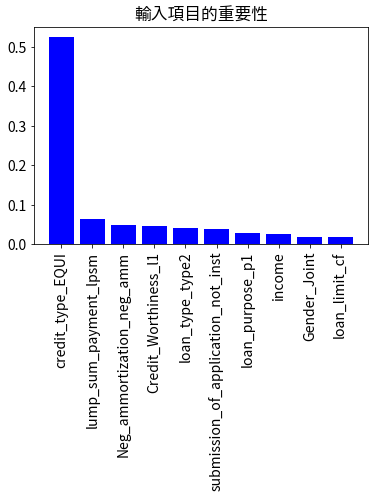

In [ ]:
# 重要性分析
importances = algorithm.feature_importances_
w = pd.Series(importances, index=x.columns)

# 按值的大小排序
u = w.sort_values(ascending=False)

# 取出前10個個欄位
v = u[:10]
#直方圖
plt.title('輸入項目的重要性')
plt.bar(range(len(v)), v, color='b', align='center')
plt.xticks(range(len(v)), v.index, rotation=90)
plt.show()